# ResNet Tests on Imagery

In [1]:
import os
import re
import zipfile
import urllib.request
import collections

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision import datasets, transforms, models


# Data Loader

In [2]:
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

image_dir = "/Users/cameronpreasmyer/Desktop/Sorted Images/1024/All"
csv_path = "/Users/cameronpreasmyer/Desktop/final_data.csv"

batch_size = 32
img_height = 1024
img_width = 1024
num_classes = 2
class_names = ['0','1']

class MetastasisDataset(Dataset):
    def __init__(self, image_dir, csv_path, transform=None):
        """
        Args:
            image_dir (str): Path to folder containing images.
            csv_path (str): Path to CSV file with 'Code' and 'Metastasis' columns.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.image_dir = image_dir
        self.transform = transform

        df = pd.read_csv(csv_path)

        # Normalize patient IDs by stripping underscores/dashes
        df['Code'] = df['Code'].astype(str).str.replace(r'[-_]', '', regex=True)
        self.label_map = dict(zip(df['Code'], df['Metastasis'].astype(str)))

        self.image_paths = []
        self.labels = []



        for fname in os.listdir(image_dir):
            fname_norm = fname.replace("-", "").replace("_", "")
            matched = False
            for pid in self.label_map:
                pid_norm = pid.replace("-", "").replace("_", "")
                # Require exact match of pid as a token
                if re.search(rf"(?:^|[-_]){pid}(?:[-_]|\.|$)", fname):
                    self.image_paths.append(os.path.join(image_dir, fname))
                    self.labels.append(int(self.label_map[pid]))
                    matched = True
                    break
            if not matched:
                print("No match for:", fname)


        # for fname in os.listdir(image_dir):
        #    # Normalize filename by stripping underscores/dashes
         #   fname_norm = fname.replace("-", "").replace("_", "")
          #  for pid in self.label_map:
           #     if pid in fname_norm:
            #        self.image_paths.append(os.path.join(image_dir, fname))
             #       self.labels.append(int(self.label_map[pid]))
              #      break

        print(f"Loaded {len(self.image_paths)} labeled images.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

Using device: cpu


In [3]:
class MetastasisDataset(Dataset):
    def __init__(self, image_dir, csv_path, transform=None):
        self.image_dir = image_dir
        self.transform = transform

        df = pd.read_csv(csv_path)

        # Normalize codes (remove dashes/underscores)
        df['Code'] = df['Code'].astype(str).str.replace(r'[-_]', '', regex=True)
        self.label_map = dict(zip(df['Code'], df['Metastasis'].astype(str)))

        self.image_paths = []
        self.labels = []

        for fname in os.listdir(image_dir):
            # Normalize filename (remove dashes/underscores)
            fname_norm = fname.replace("-", "").replace("_", "")
            matched = False
            for pid in self.label_map:
                pid_norm = pid.replace("-", "").replace("_", "")
                if pid_norm in fname_norm:
                    self.image_paths.append(os.path.join(image_dir, fname))
                    self.labels.append(int(self.label_map[pid]))
                    matched = True
                    break
            if not matched:
                print(f"Unmatched file: {fname}")

        print(f"Loaded {len(self.image_paths)} labeled images.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label


# Transforms & Data Loader

In [4]:
train_transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


full_dataset = MetastasisDataset(image_dir=image_dir, csv_path=csv_path, transform=val_transform)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_paths, val_paths, train_labels, val_labels = train_test_split(
    full_dataset.image_paths,
    full_dataset.labels,
    test_size=0.2,
    stratify=full_dataset.labels,
    random_state=42
)

# Wrap back into Dataset objects
train_dataset = MetastasisDataset(image_dir=image_dir, csv_path=csv_path, transform=train_transform)
train_dataset.image_paths, train_dataset.labels = train_paths, train_labels

val_dataset = MetastasisDataset(image_dir=image_dir, csv_path=csv_path, transform=val_transform)
val_dataset.image_paths, val_dataset.labels = val_paths, val_labels
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Train dataset size: {len(train_dataset)}, Val dataset size: {len(val_dataset)}")

Unmatched file: AST_B37000-BCL3 - 2018-05-28 21.13.26.png
Unmatched file: AST_B39561-HE - 2018-05-28 21.33.56.png
Unmatched file: AST_B81294-PIR - 2018-05-29 15.26.43.png
Unmatched file: AST_B09150-ANX - 2018-05-25 10.16.19.png
Unmatched file: EL-B176-PBP.png
Unmatched file: EL-B176-ANX.png
Unmatched file: AST_B78734-PIR - 2018-05-29 13.30.58.png
Unmatched file: AST_B40528-BCL2 - 2018-05-29 00.31.11.png
Unmatched file: AST_B24256-PBP - 2018-05-28 13.32.15.png
Unmatched file: AST_B95288-ANX - 2018-05-29 19.34.46.png
Unmatched file: AST_B78630-PIR - 2018-05-29 11.32.35.png
Unmatched file: AST_B32792-BCL2 - 2018-05-28 19.12.28.png
Unmatched file: AST_B40240-BCL2 - 2018-05-28 23.04.51.png
Unmatched file: EL-B010-HE.png
Unmatched file: AST_B21296-PIR - 2018-05-25 13.05.38.png
Unmatched file: AST_B31294-PIR - 2018-05-28 15.40.45.png
Unmatched file: EL-B176-MITF.png
Unmatched file: AST_B09150-PIR - 2018-05-25 03.31.44.png
Unmatched file: AST_B24256-PIR - 2018-05-28 13.26.38.png
Unmatched file

### Note to add EL-0 to final CSV file as there are no EL-0xxxxx patients represented. Data on these patients in Onkos_Todo.csv in "Raw_CSV" folder

# Block for checking class imbalance

In [5]:
counts = collections.Counter(full_dataset.labels)
train_counts = collections.Counter(train_dataset.labels)
val_counts = collections.Counter(val_dataset.labels)

print(f'Metastasis Count in Full Dataset: {counts[1]}')
print(f'Non-Metastatic Count in Full Dataset: {counts[0]}')
print(f'Class imbalance in the Full dataset is: {counts[1] / (counts[0]+counts[1])} for Metastasis Representation')
print()
print(f'Class Imbalance Count in Train Dataset: {train_counts[1] / (train_counts[0]+train_counts[1])}')
print(f'Class Imbalance Count in Validation Dataset: {val_counts[1] / (val_counts[0]+val_counts[1])}')
print()
if abs((train_counts[1] / (train_counts[0]+train_counts[1])) - val_counts[1] / (val_counts[0]+val_counts[1])) < 0.03:
    print("Training and Test sets are balanced")
else:    
    print("Training and Test sets are not balanced")

Metastasis Count in Full Dataset: 365
Non-Metastatic Count in Full Dataset: 580
Class imbalance in the Full dataset is: 0.3862433862433862 for Metastasis Representation

Class Imbalance Count in Train Dataset: 0.3862433862433862
Class Imbalance Count in Validation Dataset: 0.3862433862433862

Training and Test sets are balanced


# Getting Pretrained Layers and adding new layers

In [6]:
feature_extract = True 

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

if feature_extract:
    for param in model.parameters():
        param.requires_grad = False



model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),   
    nn.ReLU(),                              
    nn.Dropout(0.5),                        
    nn.Linear(256, num_classes)            
)
for param in model.fc.parameters():
    param.requires_grad = True
for param in model.layer4.parameters():
    param.requires_grad = True
model.to(device)
print(f"ResNet18 Parameters: {sum(p.numel() for p in model.parameters()):,}")

ResNet18 Parameters: 11,308,354


In [7]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Training Utility Functions

In [8]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train the model for one epoch."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(dataloader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


def evaluate(model, dataloader, criterion, device):
    """Evaluate the model."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, digits=4)

    return epoch_loss, epoch_acc, cm, report


def train_model(model, train_loader, val_loader, num_epochs=10, lr=0.001):
    """
    Train and evaluate a model.

    Returns:
        Dictionary with training history
    """
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 30)

        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, cm, report = evaluate(model, val_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print("\nConfusion Matrix:\n", cm)
        scheduler.step()

    return history


def plot_training_history(history, title="Training History"):
    """Plot training and validation loss/accuracy."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Val Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title(f'{title} - Loss')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(history['train_acc'], label='Train Acc')
    ax2.plot(history['val_acc'], label='Val Acc')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title(f'{title} - Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


# Executive Block

Testing Pretrained ResNet18 on Metastasis Images

Epoch 1/4
------------------------------


Evaluating: 100%|██████████| 6/6 [01:27<00:00, 14.54s/it]


Train Loss: 0.1204, Train Acc: 95.37%
Val Loss: 0.1936, Val Acc: 93.65%

Confusion Matrix:
 [[107   9]
 [  3  70]]

Epoch 2/4
------------------------------


Evaluating: 100%|██████████| 6/6 [01:27<00:00, 14.57s/it]


Train Loss: 0.1069, Train Acc: 96.30%
Val Loss: 0.1344, Val Acc: 93.12%

Confusion Matrix:
 [[108   8]
 [  5  68]]

Epoch 3/4
------------------------------


Evaluating: 100%|██████████| 6/6 [01:29<00:00, 14.85s/it]


Train Loss: 0.0590, Train Acc: 97.88%
Val Loss: 0.1460, Val Acc: 93.65%

Confusion Matrix:
 [[111   5]
 [  7  66]]

Epoch 4/4
------------------------------


Evaluating: 100%|██████████| 6/6 [01:27<00:00, 14.55s/it]


Train Loss: 0.0604, Train Acc: 97.75%
Val Loss: 0.2079, Val Acc: 89.95%

Confusion Matrix:
 [[106  10]
 [  9  64]]


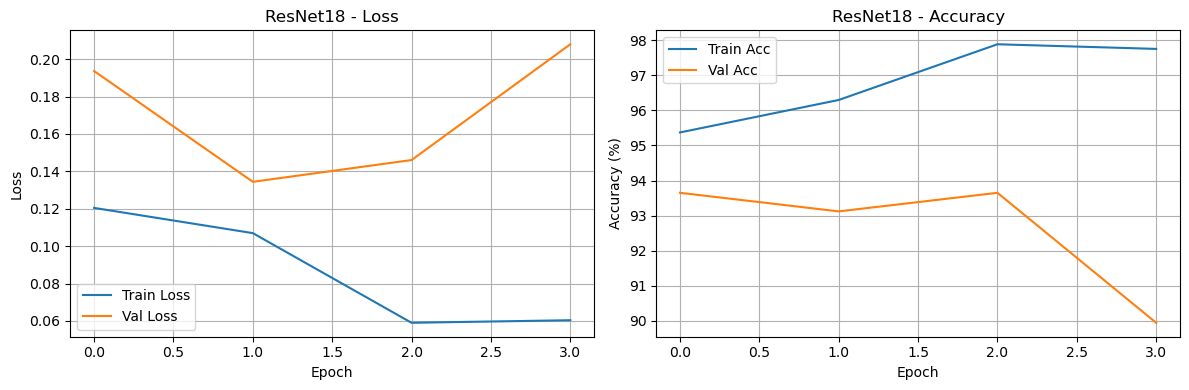


Final Results: {'ResNet18': 89.94708994708995}


In [10]:
if __name__ == "__main__":
    print("=" * 60)
    print("Testing Pretrained ResNet18 on Metastasis Images")
    print("=" * 60)

    test_epochs = 4
    results = {}

    try:
        history = train_model(model, train_loader, val_loader, num_epochs=test_epochs, lr=1e-4)
        results["ResNet18"] = history["val_acc"][-1]
        plot_training_history(history, "ResNet18")
    except Exception as e:
        print(f"Error in ResNet18: {e}")
        results["ResNet18"] = 0

    print("\nFinal Results:", results)
